# Bagging Machine
Should I bag that for you?

In [2]:
import os
import itertools
import h5py
import json
import sys
import numpy as np

try:
    import cPickle as pickle
except:
    import pickle
import time

from sklearn import linear_model
# from keras.models import Sequential
# from keras.models import load_model
# from keras.layers import Dense, Activation
# from keras.models import model_from_json
# import keras

import matplotlib.pyplot as plt
import pprint
import seaborn as sns

from tqdm import tqdm
from IPython.display import clear_output

# Intro

Density Functional Theory(DFT) is one of the most popular and successful methods for quantum mechanical simulations of matter. While it is formally exact, approximations of eXchange Correlation(XC) functionals have to be made. The accuracy of this method depends on the choice of approximations. Recent advances in computer vision and deep learning suggest that computational techniques will be a powerful new complement to the traditional toolsets of physics. The prospect of combining computer vision and deep learning is a fundamentally new approach to designing these XC functionals. This approach seeks to combine the intuitive power of physical insight with the flexibility of machine learning and high-quality training data in order to develop new routes to approximating exchange-correlation energies.

We focus on the effectiveness of machine learning techniques in finding a unique mapping between the electron density(rho) and the exchange-correlation(XC) potential of a system. My current project is uncertainty quantification for machine learned surrogate functionals. I first fit the data (extracted from higher- level hybrid functionals such as B3LYP) with optimized Local Density Approximation(LDA) and then perform model selection of various regression models on the residuals.

## Import data

The data(ground truth) for different molecules is generated using the B3LYP functional. However, B3LYP involves a lot of non-local information and needs to be calculated seperately for every system.

Our eventual goal is to come up with a generalized technique to estimate the eXchange Correlation potential for any system.

In [2]:
rho = []
epxc = []
for mol in ['H2O']:
    raw_data = h5py.File(mol+'_B3LYP_0_0_0.hdf5','r')
    rho = np.append(rho,np.array(raw_data['rho']).flatten())
    epxc = np.append(epxc, np.multiply(-1,np.array(raw_data['epsilon_xc']).flatten()))
    
rho_vector = rho.flatten()
#epxc_vector = np.multiply(-1,epxc.flatten())
epxc_vector = epxc.flatten()

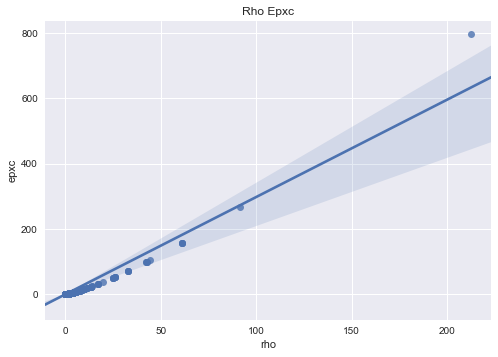

In [3]:
sns.regplot(rho,epxc)

plt.title("Rho Epxc")
plt.xlabel("rho")
plt.ylabel("epxc")
plt.show()

In the log log domain, rho and epxc exhibit an alomost linear relationship. Notice that it's not perfectly linear.

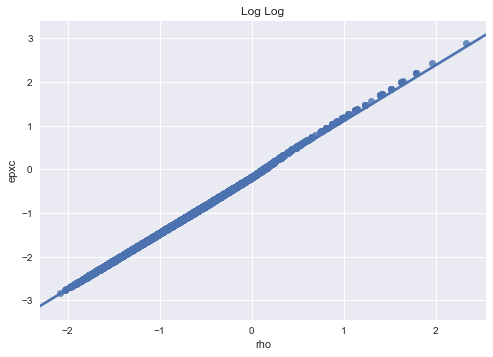

In [4]:
sns.regplot(np.log10(rho),np.log10(epxc))
plt.title("Log Log")
plt.xlabel("rho")
plt.ylabel("epxc")
plt.show()

## Log check

In [5]:
log = True

data = np.array([rho,epxc])
if log:
    data = np.log10(data)

## Linear fit residual

We exploit the fact that the relationship is almost linear. First we fit the data to a linear model and extract the residuals.

In [6]:
def fit_linear(data, mol):
    size = data.shape[1]
    x = data[0].reshape((size,1))
    y = data[1].reshape((size,1))
    
    filename = 'Linear_{}.sav'.format(mol);
    
    li_model = linear_model.LinearRegression()
    li_model.fit(x, y)
    pickle.dump(li_model, open(filename, 'wb'))
    
    # The coefficients
    print ('Coefficients: \n', li_model.coef_)
    # The mean squared error
    print ("Mean squared error: %.20f" % np.mean((li_model.predict(x) - y) ** 2))
    # Explained variance score: 1 is perfect prediction
    print ('Variance score: %.20f' % li_model.score(x, y))
    
    residual = y-li_model.predict(x)
    return np.array(residual)

In [7]:
mol = 'H2O'
residual = np.reshape(fit_linear(data,mol),data.shape[1])
res_data = np.array([rho,residual])

Coefficients: 
 [[ 1.28274486]]
Mean squared error: 0.00008366064199818799
Variance score: 0.99973560349723444851


/Users/kns/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


## Neural Net Ensemble

Now we use neural nets to create a regression model between the density (rho) and the residuals left after the linear fit.

In [8]:
def fit_nn(x, y, n_layers, n, mol, submodel_no): #can add ranges later
    size = x.shape[0]
    print(size)
    x2 = x.reshape((size,1))
    y2 = y#.reshape((1,size))
    
    fname = 'NN_{}_{}_{}_{}'.format(mol,n,n_layers,submodel_no)
    slowdown_factor = 1
    k = 1
    print (n, k)

    model = Sequential()

    model.add(Dense(output_dim=n, input_dim=1, activation="linear"))

    if n_layers > 1:
        for i in np.arange(n_layers):
            model.add(Dense(input_dim=n, output_dim=n, activation="linear"))
        model.add(Dense(input_dim=n, output_dim=1, activation='linear'))

    # model.add(Dense(input_dim = 1,output_dim =1, activation = 'linear',  init='uniform'))

    print ('model set')
    default_lr = 0.001
    adam = keras.optimizers.Adam(lr=default_lr / slowdown_factor)
    model.compile(loss='mse', optimizer=adam)
    print (model.summary())
    #print (model.get_config())
    
    model.fit(x2, y2, epochs=8, batch_size=1350, verbose = 0)
    scores = model.evaluate(x2,y2)
    
    print (scores)
    
    model_json = model.to_json()
    with open(fname+".json", "w") as json_file:
        json_file.write(model_json)
    model.save_weights(fname+".h5")
    
    

## Subsampling and fitting

However, training just one neural net over all data does not give accurate results. We use bootstrap aggregation (bagging) using multiple neural nets. We generate subsamples from the data (with replacement) and train a net on each subsample.

This also gives us robust uncertainty quantification.

###  Hyperparameters

In [9]:
no_submodels = 8;
n =10;
n_layers = 5;
size_subsample = int(0.632 * data.shape[1]) #1-1/e

In [10]:
for submodel_no in tqdm(range(no_submodels)):
    print(submodel_no)
    subsample_mask = np.random.choice(data.shape[1], size_subsample)
    x = res_data[0,subsample_mask]
    y = res_data[1,subsample_mask]
    
    fit_nn(x, y,n_layers, n, mol, submodel_no)
    clear_output(wait=True)

100%|██████████| 8/8 [00:18<00:00,  2.36s/it]


## Prediction

Now we generate predictions for the whole dataset from each neural network. We then add the predicted residuals to the linear model we created before.

In [11]:
def predict_nn(x, n_layers, n, mol, submodel_no):
    fname = 'NN_{}_{}_{}_{}'.format(mol,n,n_layers,submodel_no)
    slowdown_factor = 1
     
    json_file = open(fname+".json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    
    model.load_weights(fname+".h5")
    print("Loaded model from disk")
    
    default_lr = 0.001
    adam = keras.optimizers.Adam(lr=default_lr / slowdown_factor)
    model.compile(loss='mse', optimizer=adam)
    
    predictions = model.predict(x)
    print(predictions.shape)
    return predictions

### Load models and make predictions

In [12]:
lin_fname = 'Linear_{}.sav'.format(mol);
li_model = pickle.load(open(lin_fname, 'rb'))
predicted_line = np.array(list(map(lambda x: li_model.predict(data[0,x]), np.arange(data.shape[1]))))

predictions = np.zeros((no_submodels, data.shape[1]))
print(predictions[0].shape)

for submodel_no in tqdm(range(no_submodels)):
    x = res_data[0]
    y = res_data[1]
    predictions[submodel_no] = predict_nn(x, n_layers, n, mol, submodel_no).reshape(data.shape[1])
    clear_output(wait=True)

100%|██████████| 8/8 [00:09<00:00,  1.15s/it]


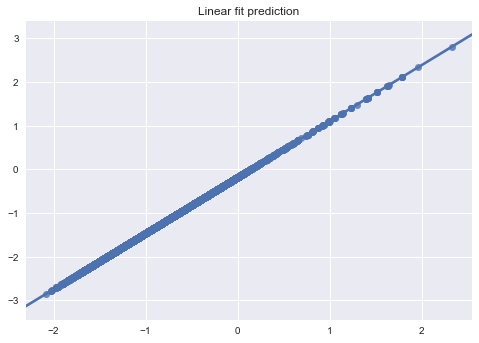

In [13]:
p2 = np.reshape(predicted_line,data.shape[1])
sns.regplot(data[0],p2)
plt.title("Linear fit prediction")
#plt.xlabel('$\rho$')
plt.show()

In [14]:
mu = np.mean(predictions,axis = 0)
sig = np.std(predictions,axis = 0)
pred_data = mu+p2

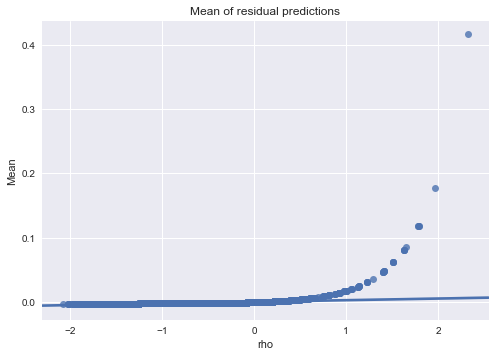

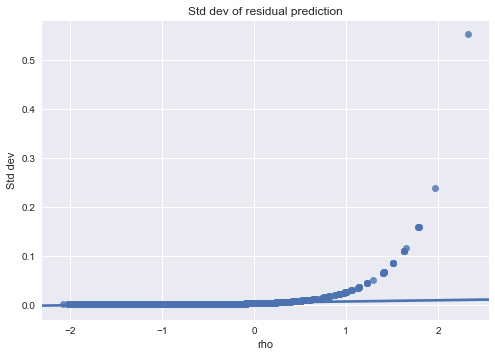

In [15]:
sns.regplot(data[0],mu)
plt.title("Mean of residual predictions")
plt.xlabel('rho')
plt.ylabel('Mean')
plt.show()

sns.regplot(data[0],sig)
plt.xlabel('rho') #$\rho$
plt.ylabel('Std dev')
plt.title("Std dev of residual prediction")
plt.show()

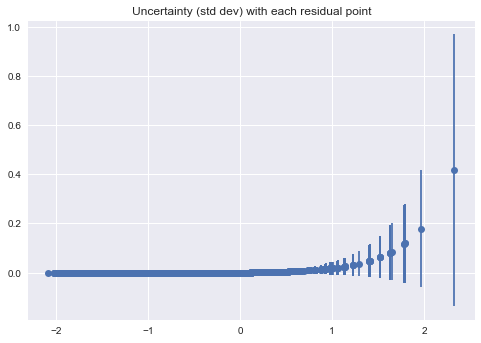

In [16]:
plt.errorbar(data[0], mu, sig, fmt='o')
plt.title('Uncertainty (std dev) with each residual point')
#plt.xlabel('$\rho$')
plt.show()

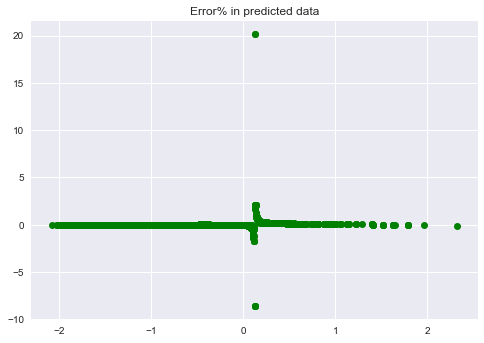

In [17]:
#sig2 = np.std(pred_data,axis = 0)

plt.plot(data[0], (data[1]-pred_data)/data[1],'go')   
plt.title('Error% in predicted data')
#plt.xlabel('$\rho$')
plt.show()

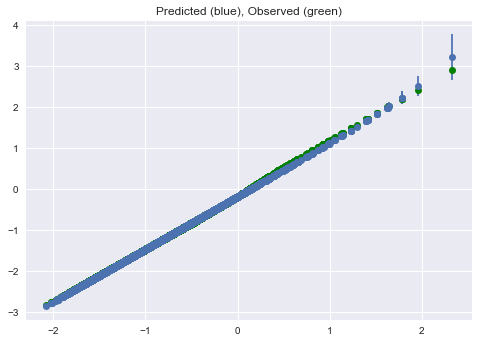

In [18]:
plt.plot(data[0], data[1],'go')       #data[0], pred_data,'bo',
plt.errorbar(data[0], pred_data, sig, fmt='o')
plt.title('Predicted (blue), Observed (green)')
#plt.xlabel('$\rho$')
plt.show()

In [1]:
FileNotFoundError??

Init signature: FileNotFoundError(self, /, *args, **kwargs)
Docstring:      File not found.
Type:           type


In [5]:
fname = './predictions_submodel_4.h5'
hf = h5py.File(fname, 'r')

In [8]:
h5keys = list(hf.keys())

In [12]:
for i in h5keys: print(hf[i])

<HDF5 dataset "LDA_predict_y": shape (983569, 1), type "<f8">
<HDF5 dataset "NN_predict_y": shape (983569, 1), type "<f4">
<HDF5 dataset "density": shape (983569, 1), type "<f8">
<HDF5 dataset "error": shape (983569, 1), type "<f8">
<HDF5 dataset "predict_y": shape (983569, 1), type "<f8">
<HDF5 dataset "y": shape (983569, 1), type "<f8">
